### Load the MNIST and CIFAR10 Datasets
- Both datasets will be loaded from the torch.vision python package to make the import easier

In [14]:
# Load the Datasets
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

# Use GPU as the device if possible
default_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(default_device)

cuda


In [15]:
default_batch_size = 64

In [16]:
# Load MNIST
# MNIST transform to preprocess the data
transform_mnist = transforms.Compose([transforms.ToTensor()])
# TODO - normalize the training and test datasets

# Download and load the training data
trainset_mnist = datasets.MNIST('./data/MNIST_data/', download=True, train=True, transform=transform_mnist)
trainloader_mnist = torch.utils.data.DataLoader(trainset_mnist, batch_size=default_batch_size, shuffle=True)

# Download and load the test data
testset_mnist = datasets.MNIST('./data/MNIST_data/', download=True, train=False, transform=transform_mnist)
testloader_mnist = torch.utils.data.DataLoader(testset_mnist, batch_size=default_batch_size, shuffle=True)

In [102]:
# LOAD CIFAR 10
# Cifar transform to preprocess the data
transform_cifar = transforms.Compose([transforms.ToTensor()])

# Download and load the training data
trainset_cifar = datasets.CIFAR10('./data/CIFAR10_data/', download=True, train=True, transform=transform_cifar)
trainloader_cifar = torch.utils.data.DataLoader(trainset_cifar, batch_size=default_batch_size, shuffle=True)

# Download and load the test data
testset_cifar = datasets.CIFAR10('./data/CIFAR10_data/', download=True, train=False, transform=transform_cifar)
testloader_cifar = torch.utils.data.DataLoader(testset_cifar, batch_size=20, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [100]:
# VAE Model Definition
class VAE_linear(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, dropout_rate=0.2):
        super(VAE_linear, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size, device=default_device),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size, device=default_device),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, latent_size * 2, device=default_device))  # x2 for mean and variance

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size, device=default_device),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size, device=default_device),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, input_size, device=default_device),
            nn.Sigmoid()  # Sigmoid activation for pixel values between 0 and 1
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std, device=default_device)
        return mu + eps * std

    def forward(self, x):
        # Encode
        encoding = self.encoder(x)
        mu, log_var = torch.chunk(encoding, 2, dim=1)

        # Reparameterization trick
        z = self.reparameterize(mu, log_var)

        # Decode
        reconstruction = self.decoder(z)

        return reconstruction, mu, log_var


class VAE_conv(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE_conv, self).__init__()
        channel_size = 32

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, channel_size, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(channel_size, channel_size * 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(channel_size * 2, channel_size * 4, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(channel_size * 4 * 4 * 4, latent_size * 2)  # Adjusted for mu and log_var
        ).to(default_device)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, channel_size * 4 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (channel_size * 4, 4, 4)),
            nn.ConvTranspose2d(channel_size * 4, channel_size * 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(channel_size * 2, channel_size, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(channel_size, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        ).to(default_device)

        # Latent space
        self.fc_mu = nn.Linear(hidden_size, latent_size).to(default_device)
        self.fc_log_var = nn.Linear(hidden_size, latent_size).to(default_device)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        # Encode
        x = self.encoder(x)
        mu, log_var = torch.chunk(x, 2, dim=1)  # Split into mu and log_var

        # Reparameterization trick
        z = self.reparameterize(mu, log_var)

        # Decode
        x_recon = self.decoder(z)

        return x_recon, mu, log_var

# VAE Loss function
def vae_loss_function(recon_x, x, mu, log_var, input_size):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, input_size), reduction='sum')

    # KL Divergence
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return (BCE, KLD)

# VAE Training function
def train_vae_linear(model, trainloader, optimizer, num_epochs, input_size):
    # Training loop
    for epoch in range(num_epochs):
        for i, data in enumerate(trainloader, 0):
            inputs, _ = data
            inputs = inputs.view(-1, input_size).to(default_device)
            inputs = Variable(inputs)

            # PyTorch accumulates gradients on subsequent backward passes - so zero the grads
            optimizer.zero_grad()

            # Forward pass
            recon_batch, mu, log_var = model(inputs)

            # Binary cross entropy, KL divergence
            (BCE, KLD) = vae_loss_function(recon_batch, inputs, mu, log_var, input_size)
            totalloss = BCE + KLD

            # Backward pass
            totalloss.backward()

            # Update weights
            optimizer.step()

            if i % 500 == 0:
                print('Epoch [{}/{}], Step [{}/{}], BCE: {:.4f}, KLD: {:.4f}, Total Loss: {:.4f}'
                    .format(epoch+1, num_epochs, i+1, len(trainloader), BCE.item(), KLD.item(), totalloss.item()))

def vae_loss_function_conv(recon_x, x, mu, log_var):
    # Flatten recon_x to match the shape of x
    recon_x_flat = recon_x.view(x.size())

    BCE = nn.functional.binary_cross_entropy(recon_x_flat, x, reduction='sum')

    # KL Divergence
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return (BCE, KLD)

def train_vae_conv(model, trainloader, optimizer, num_epochs, input_size):
    # Training loop
    for epoch in range(num_epochs):
        for i, data in enumerate(trainloader, 0):
            inputs, _ = data
            inputs = inputs.to(default_device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            recon_batch, mu, log_var = model(inputs)

            # Reshape the inputs for the loss function
            inputs_flat = inputs.view(-1, 3, 32, 32)
            recon_batch_flat = recon_batch.view(-1, 3, 32, 32)

            # Binary cross entropy, KL divergence
            (BCE, KLD) = vae_loss_function_conv(recon_batch_flat, inputs, mu, log_var)
            loss = BCE + KLD

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            if i % 500 == 0:
                print('Epoch [{}/{}], Step [{}/{}], BCE: {:.4f}, KLD: {:.4f}, Total Loss: {:.4f}'
                    .format(epoch+1, num_epochs, i+1, len(trainloader), BCE.item(), KLD.item(), loss.item()))



In [6]:
# GAN Model Definition

In [7]:
# WGAN Model Definition

## Train the Models - MNIST
Start training the VAE, GAN and WGAN models with the MNIST dataset.

In [60]:
# MNIST Data Training
input_size = 28 * 28 # Size of MNIST images - 784
hidden_size = 512 # Hidden size for hidden layer
latent_size = 128 # Latent size for latent vector -- trial [2, 64, 128]
learning_rate = 0.001 # Learning rate for the optimizer
num_epochs = 10 # Number of epochs to train for

# Initialize the model
vae_model_mnist = VAE_linear(input_size, hidden_size, latent_size)

# Optimizer
optimizer = optim.Adam(vae_model_mnist.parameters(), lr=learning_rate)

# Train the model
train_vae_linear(vae_model_mnist, trainloader_mnist, optimizer, num_epochs, input_size)


Epoch [1/10], Step [1/938], BCE: 34886.2578, KLD: 13.9874, Total Loss: 34900.2461
Epoch [1/10], Step [501/938], BCE: 10227.0547, KLD: 586.2658, Total Loss: 10813.3203
Epoch [2/10], Step [1/938], BCE: 9200.0635, KLD: 827.8794, Total Loss: 10027.9434


KeyboardInterrupt: 

In [109]:
# CIFAR 10 Data Training - Linear
input_size = 32 * 32 * 3 # Size of CIFAR images - 3072
hidden_size = 512 # Hidden size for hidden layer
latent_size = 512 # Latent size for latent vector
learning_rate = 0.001 # Learning rate for the optimizer
num_epochs = 10 # Number of epochs to train for

# Initialize the model
vae_model_cifar_linear = VAE_linear(input_size, hidden_size, latent_size)
# Optimizer
optimizer = optim.Adam(vae_model_cifar_linear.parameters(), lr=learning_rate)

# Train the model
train_vae_linear(vae_model_cifar_linear, trainloader_cifar, optimizer, num_epochs, input_size)


Epoch [1/10], Step [1/782], BCE: 136639.2188, KLD: 124.5886, Total Loss: 136763.8125
Epoch [1/10], Step [501/782], BCE: 127963.7344, KLD: 740.4352, Total Loss: 128704.1719
Epoch [2/10], Step [1/782], BCE: 125143.3125, KLD: 999.0769, Total Loss: 126142.3906
Epoch [2/10], Step [501/782], BCE: 130276.9609, KLD: 539.6003, Total Loss: 130816.5625
Epoch [3/10], Step [1/782], BCE: 126380.7188, KLD: 688.4216, Total Loss: 127069.1406
Epoch [3/10], Step [501/782], BCE: 126546.2500, KLD: 896.9194, Total Loss: 127443.1719
Epoch [4/10], Step [1/782], BCE: 125565.6250, KLD: 983.2379, Total Loss: 126548.8594
Epoch [4/10], Step [501/782], BCE: 126847.3594, KLD: 754.4478, Total Loss: 127601.8047
Epoch [5/10], Step [1/782], BCE: 126719.7109, KLD: 786.7843, Total Loss: 127506.4922
Epoch [5/10], Step [501/782], BCE: 126981.8125, KLD: 768.8331, Total Loss: 127750.6484
Epoch [6/10], Step [1/782], BCE: 123747.5000, KLD: 753.5976, Total Loss: 124501.0938
Epoch [6/10], Step [501/782], BCE: 124403.9375, KLD: 64

In [101]:
# CIFAR 10 Data Training - Conv
input_size = 32 * 32 * 3 # Size of CIFAR images - 3072
hidden_size = 512 # Hidden size for hidden layer ** relationship in the cnn architecture so can't just change this
latent_size = 512 # Latent size for latent vector -- trial [2, 64, 128]
learning_rate = 0.001 # Learning rate for the optimizer
num_epochs = 50 # Number of epochs to train for

# CNN

# Initialize the model
vae_model_cifar = VAE_conv(input_size, hidden_size, latent_size)

# Optimizer
optimizer = optim.Adam(vae_model_cifar.parameters(), lr=learning_rate)

# Train the model
train_vae_conv(vae_model_cifar, trainloader_cifar, optimizer, num_epochs, input_size)


Epoch [1/50], Step [1/782], BCE: 136278.0625, KLD: 10.8022, Total Loss: 136288.8594
Epoch [1/50], Step [501/782], BCE: 117916.7500, KLD: 2170.9756, Total Loss: 120087.7266
Epoch [2/50], Step [1/782], BCE: 118746.5391, KLD: 2289.9055, Total Loss: 121036.4453
Epoch [2/50], Step [501/782], BCE: 121016.6328, KLD: 2206.9414, Total Loss: 123223.5781
Epoch [3/50], Step [1/782], BCE: 116481.7500, KLD: 2335.0601, Total Loss: 118816.8125
Epoch [3/50], Step [501/782], BCE: 117086.3594, KLD: 2253.1292, Total Loss: 119339.4922
Epoch [4/50], Step [1/782], BCE: 116745.4062, KLD: 2389.9263, Total Loss: 119135.3359
Epoch [4/50], Step [501/782], BCE: 113858.9688, KLD: 2335.1941, Total Loss: 116194.1641
Epoch [5/50], Step [1/782], BCE: 116323.4062, KLD: 2214.7981, Total Loss: 118538.2031
Epoch [5/50], Step [501/782], BCE: 115704.5625, KLD: 2441.9141, Total Loss: 118146.4766
Epoch [6/50], Step [1/782], BCE: 116699.2422, KLD: 2400.2839, Total Loss: 119099.5234
Epoch [6/50], Step [501/782], BCE: 114440.0469

## Testing Evaluation

Average loss: 7442.0887


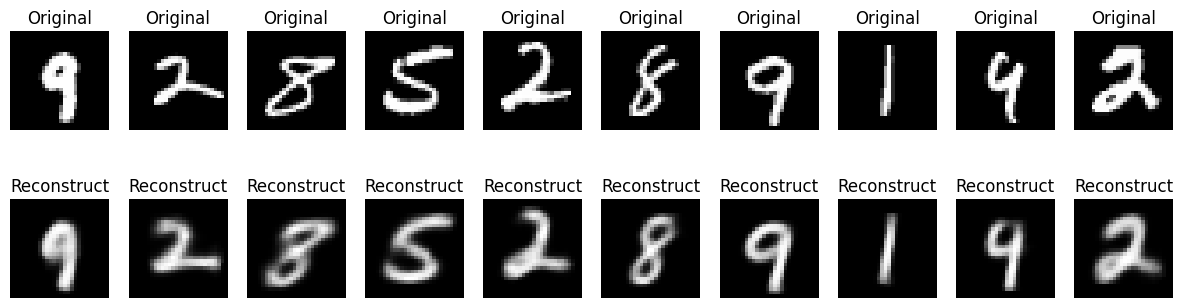

RuntimeError: shape '[-1, 784]' is invalid for input of size 196608

In [40]:
import matplotlib.pyplot as plt
import numpy as np

def vae_create_original_and_reconstructed_images_arrays(model, testloader, input_size):
    model.eval()

    # Initialize lists to store original and reconstructed images for testing
    test_original_images = []
    test_reconstructed_images = []

    # Calculate the average reconstruction loss on the testing dataset
    test_average_loss = 0.0
    test_num_batches = 0

    # Evaluate on the entire testing dataset
    with torch.no_grad():
        for data in testloader:
            inputs, _ = data
            inputs = inputs.view(-1, input_size).to(default_device)
            
            # Forward pass
            recon_batch, mu, log_var = vae_model_mnist(inputs)
            
            # Compute loss
            (BCE, KLD) = vae_loss_function(recon_batch, inputs, mu, log_var, input_size)
            loss = BCE + KLD
            test_average_loss += loss.item()
            test_num_batches += 1

            # Convert to numpy arrays for visualization
            test_original_images.append(inputs.cpu().numpy())
            test_reconstructed_images.append(recon_batch.cpu().numpy())

    # Concatenate the batches
    test_original_images = np.concatenate(test_original_images, axis=0)
    test_reconstructed_images = np.concatenate(test_reconstructed_images, axis=0)

    test_average_loss /= test_num_batches
    print('Average loss: {:.4f}'.format(test_average_loss))
    return test_original_images, test_reconstructed_images, test_average_loss

def vae_visualize_original_and_reconstructed(original_images, reconstructed_images, shape, n_samples=10):
    # Select n random images
    indices = np.random.choice(len(original_images), n_samples, replace=False)

    # Plot the original images
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 4))

    for i, index in enumerate(indices):
        axes[0, i].imshow(original_images[index].reshape(shape), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')

        axes[1, i].imshow(reconstructed_images[index].reshape(shape), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstruct')
    plt.show()


# Visualize the original and reconstructed images -- MNIST
test_original_images, test_reconstructed_images, test_average_loss = vae_create_original_and_reconstructed_images_arrays(vae_model_mnist, testloader_mnist, input_size)
vae_visualize_original_and_reconstructed(test_original_images, test_reconstructed_images, shape=(28,28))


# Visualize the original and reconstructed images -- CIFAR 10
test_original_images_cifar, test_reconstructed_images_cifar, test_average_loss_cf = vae_create_original_and_reconstructed_images_arrays(vae_model_cifar, testloader_cifar, input_size)
vae_visualize_original_and_reconstructed(test_original_images_cifar, test_reconstructed_images_cifar, shape=(32,32,3))


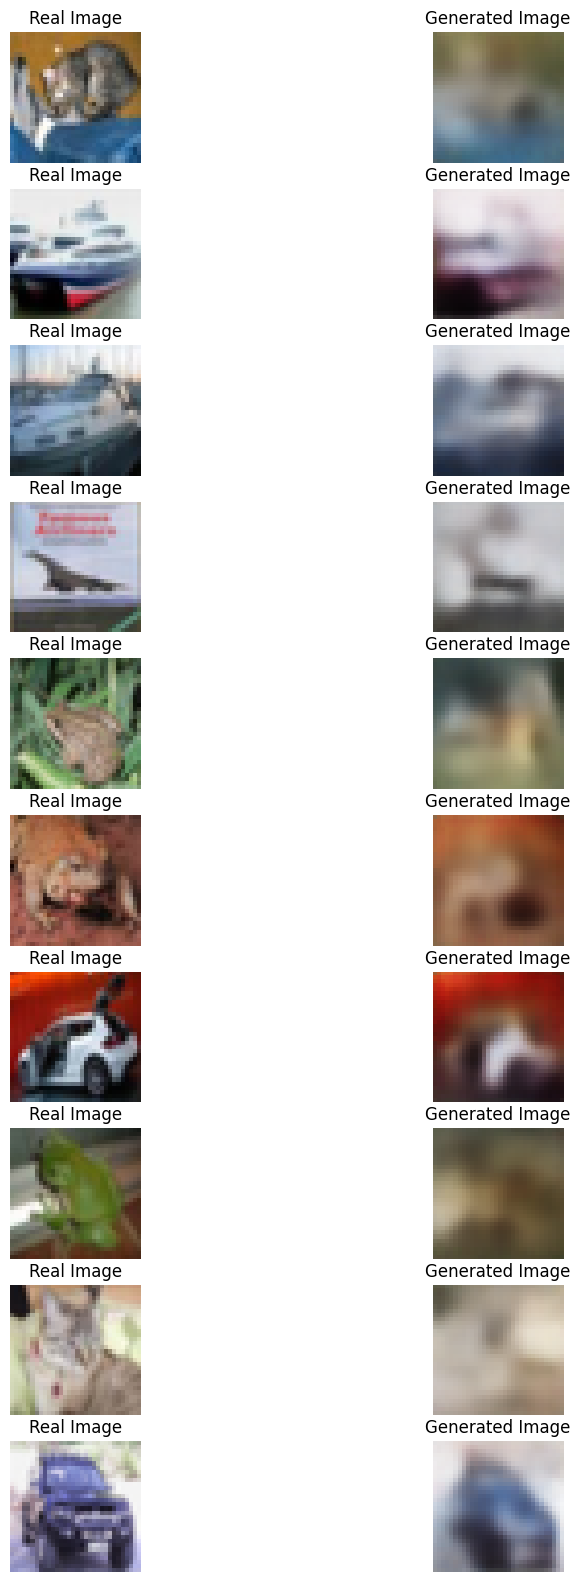

In [111]:
import torchvision
import torchvision.transforms as transforms

def generate_and_show_cifar(vae_model, data_loader, num_rows=5):
    vae_model.eval()

    with torch.no_grad():
        # Get a batch of real images
        real_images, _ = next(iter(data_loader))
        real_images = real_images.to(default_device)

        # Generate images using the VAE
        recon_images, _, _ = vae_model(real_images)

    # Display the images
    fig, axes = plt.subplots(num_rows, 2, figsize=(10, 2 * num_rows))
    for i in range(num_rows):
        # Display real images
        axes[i, 0].imshow(torchvision.utils.make_grid(real_images[i].cpu(), nrow=1).permute(1, 2, 0))
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Real Image')

        # Display generated images
        axes[i, 1].imshow(torchvision.utils.make_grid(recon_images[i].cpu(), nrow=1).permute(1, 2, 0))
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Generated Image')

    plt.show()

# Assuming your VAE model and DataLoader are already defined
generate_and_show_cifar(vae_model_cifar, testloader_cifar, num_rows=10)

Original Images:


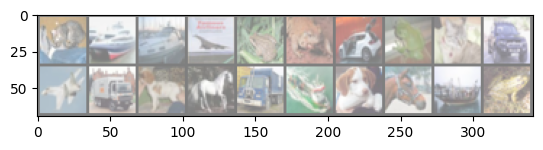

Reconstructed Images:


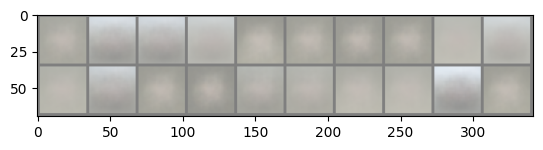

In [110]:
# Code to show the images in the training set, versus the linear images

# Function to unnormalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Function to generate and display reconstructed images from the VAE
def generate_and_show_cifar_linear(vae_model, data_loader, num_rows=1):
    vae_model.eval()
    with torch.no_grad():
        for images, _ in data_loader:
            # Display original images
            print('Original Images:')
            imshow(torchvision.utils.make_grid(images, nrow=num_rows))

            # Forward pass through the VAE
            images = images.view(-1, 3 * 32 * 32).to(default_device)
            recon_images, _, _ = vae_model(images)

            # Reshape reconstructed images for visualization
            recon_images = recon_images.view(-1, 3, 32, 32)

            # Display reconstructed images
            print('Reconstructed Images:')
            imshow(torchvision.utils.make_grid(recon_images.cpu(), nrow=num_rows))
            break  # Break after the first batch for demonstration purposes



# Compare trained and untrained images
generate_and_show_cifar_linear(vae_model_cifar_linear, testloader_cifar, num_rows=10)
